In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import mne 
from mne.viz import plot_alignment, snapshot_brain_montage
from scipy.stats import sem
import matplotlib.lines as mlines
from scipy.signal import find_peaks
import matplotlib.patches as mpatches
import h5py
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# retrieve speech responsive contacts 
speech_responsive = pd.read_csv("data\\anatomy\\speech_responsive.csv")
speech_responsive = speech_responsive['selected'].values
Env = pd.read_csv("data\\RSR\\ENV.csv")
SF = pd.read_csv("data\\RSR\\SF.csv")
Env = Env.loc[Env['normative_name'].isin(speech_responsive)]
SF = SF.loc[SF['normative_name'].isin(speech_responsive)]

In [9]:
feat = 'RSR_lowFreq'             #'RSR_highFreq' 'RSR_lowFreq'

In [10]:
# format properly
final_tobrain = pd.DataFrame(np.asarray([SF['normative_name'].values,SF['x'].values,SF['y'].values,SF['z'].values
                            ,SF[feat].values,Env[feat].values]).T,
                             columns=['normative_name','x','y','z','sf','env'])


Channel types::	seeg: 347


Text(0.16, 0.3, 'Spectral Flux')

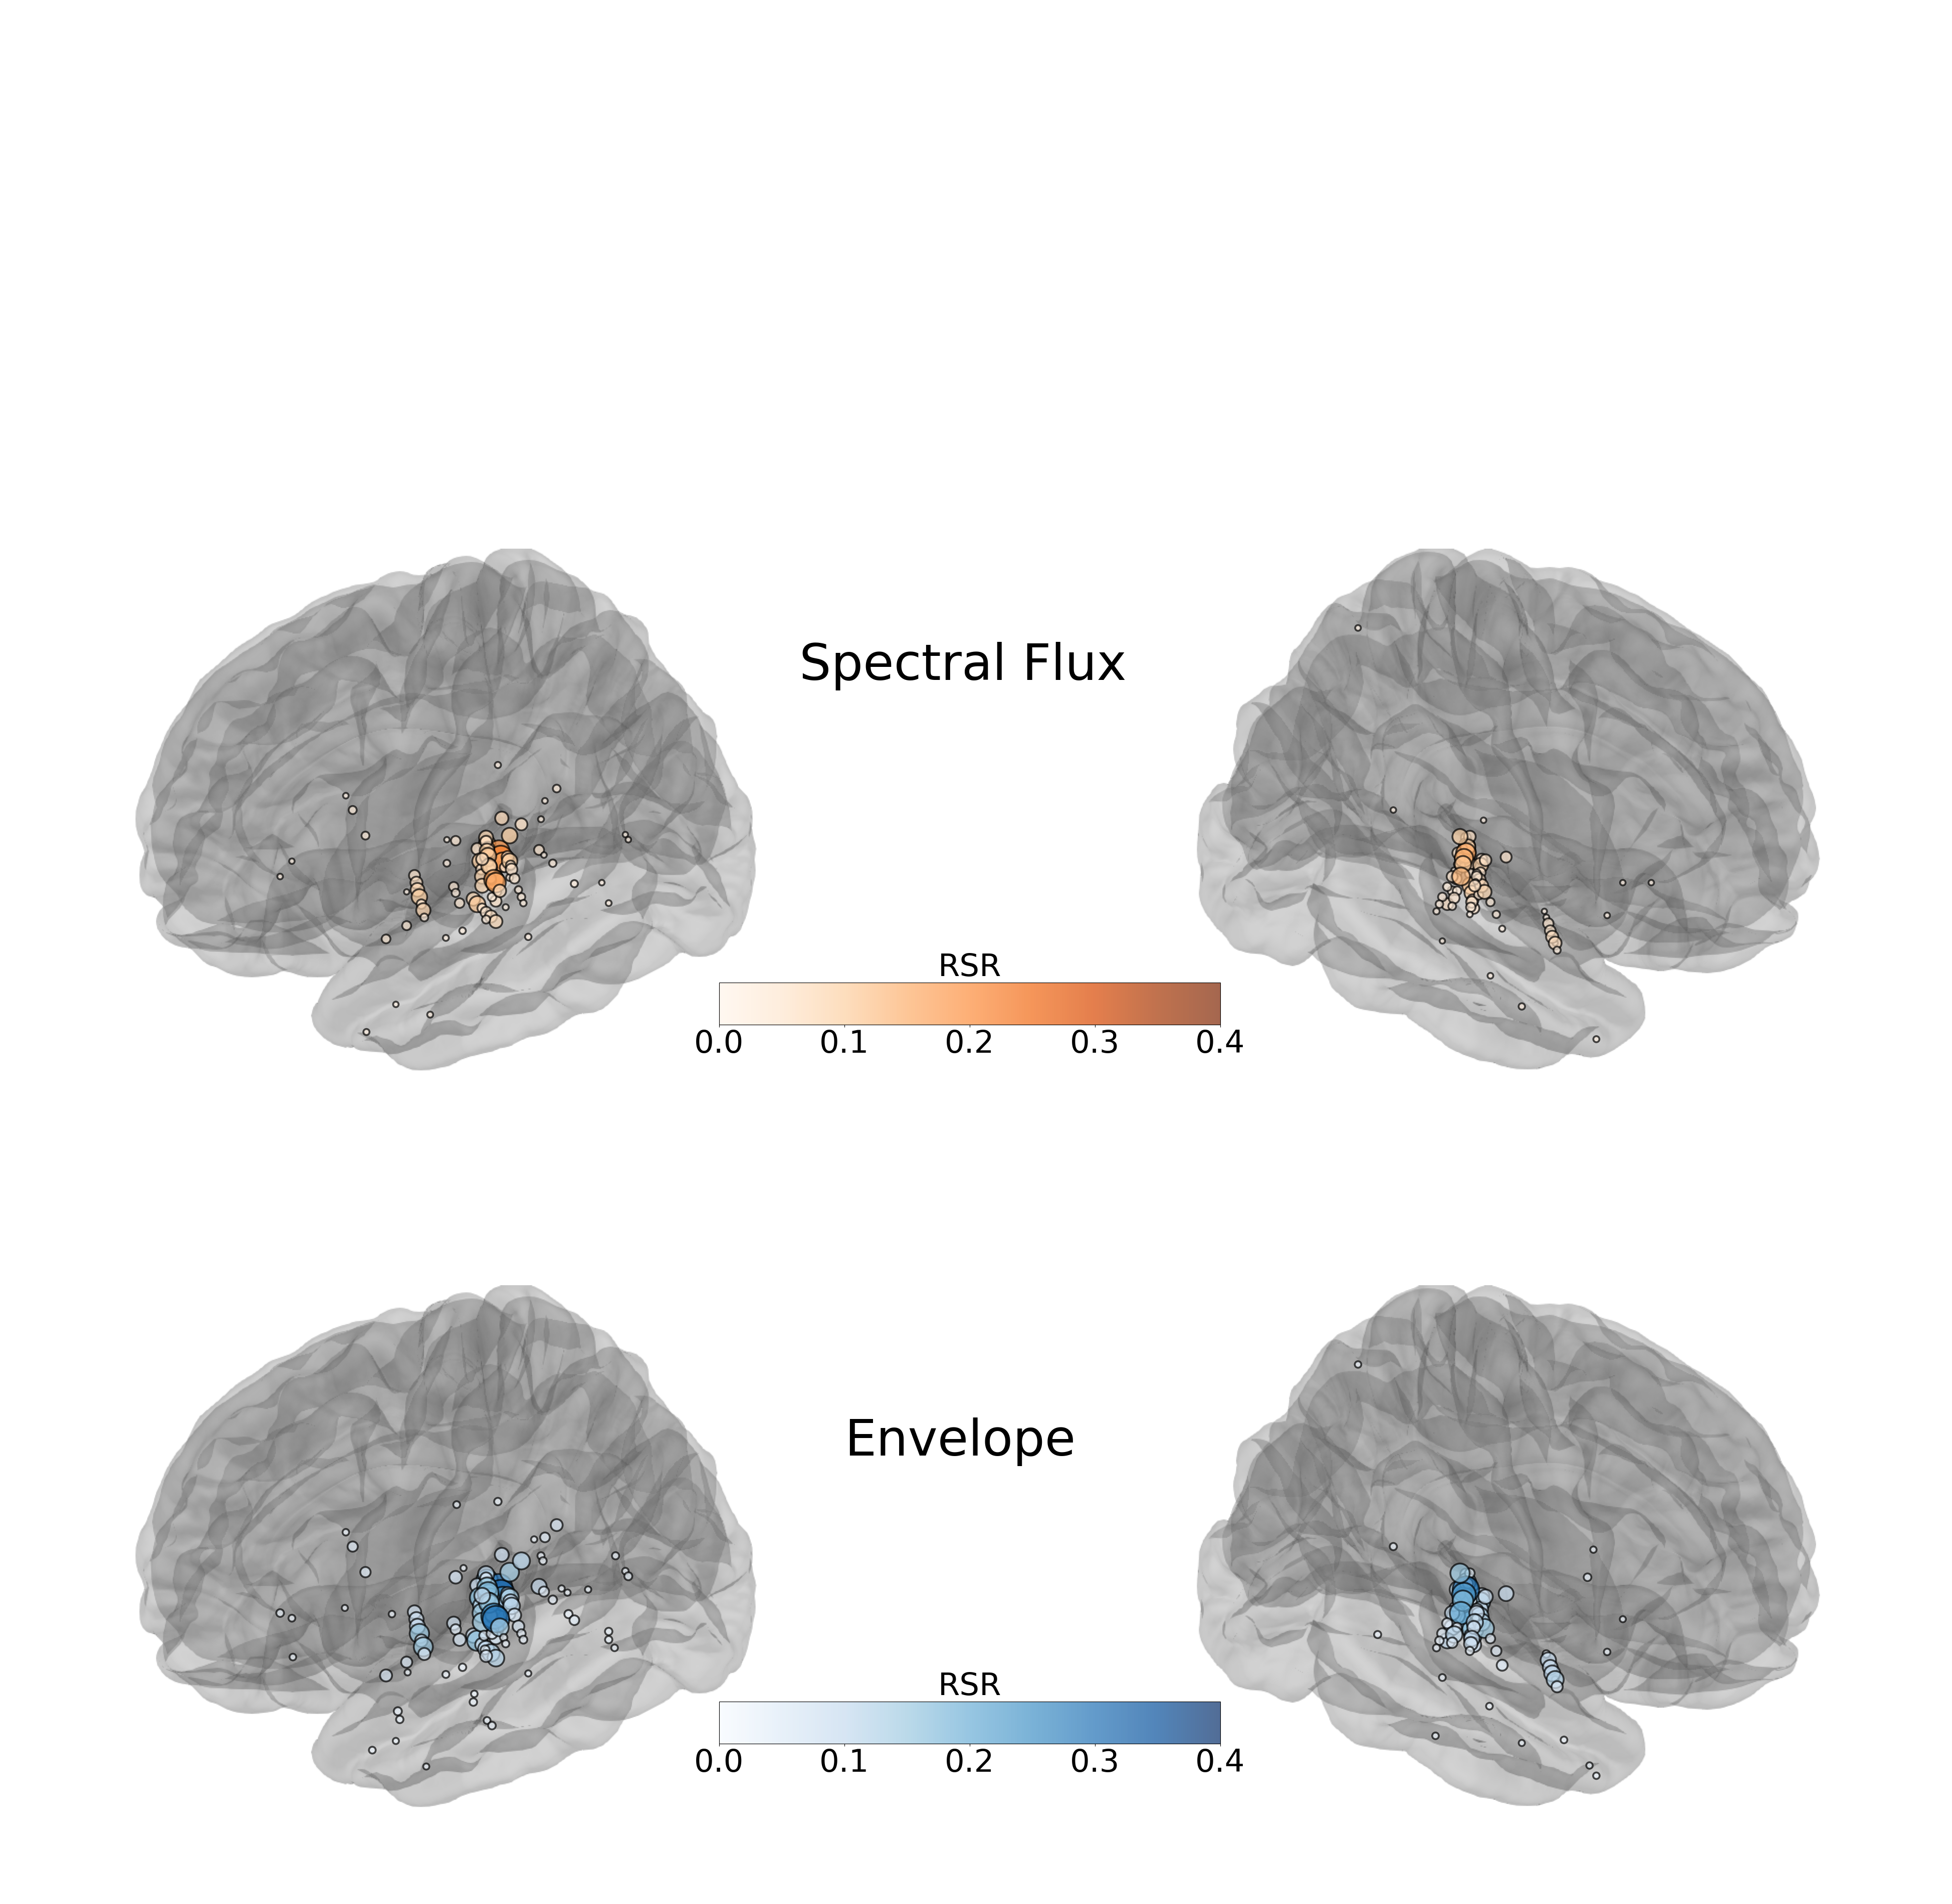

In [11]:
for i in ('x','y','z','sf','env'):
    final_tobrain[i] = final_tobrain[i].astype(float)
datas_to_plot = [final_tobrain["sf"].values,final_tobrain["env"].values]
ch_names = final_tobrain['normative_name'].values
loc = final_tobrain[['x','y','z']].values
# Declare montage
ch_pos = dict(zip(ch_names, loc))
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info_ = mne.create_info(list(ch_names), 1000., ch_types='seeg').set_montage(montage)


mne.viz.set_3d_backend("notebook")
fig = mne.viz.create_3d_figure(size=(900, 600), bgcolor='white', scene=True)
subjects_dir = "data\\anatomy\\anatomy2\\"
trans =  mne.read_trans(subjects_dir + '\\fsaverage\\fsaverage-trans.fif')
surfaces = {'brain': 1}

fig =plot_alignment(info=info_,trans=trans,subject='fsaverage',subjects_dir=subjects_dir,
                 surfaces=dict(pial=0.4),seeg=True, interaction='terrain',coord_frame='mri',fig=fig)

mne.viz.set_3d_view(fig,azimuth=-180, elevation=-70,distance = 0.32)
xy, im = snapshot_brain_montage(fig, montage)
xy_pts1 = np.vstack([xy[ch] for ch in info_['ch_names']])

mne.viz.set_3d_view(fig,azimuth=180, elevation=70,distance = 0.32)
xy,im2 = snapshot_brain_montage(fig, montage)
xy_pts2 = np.vstack([xy[ch] for ch in info_['ch_names']])


images = [im2,im,im2,im]
idxs = [0,0,1,1]
cmaaps = ['Oranges','Oranges','Blues','Blues']
fig2, axs = plt.subplots(2,2,figsize=(50, 35))

vmins = [0,0,0,0]

if feat == 'RSR_lowFreq':
    stat1 = 0.0112; stat2= 0.015
    vmaxs = [0.4,0.4,0.4,0.4]
    nbrs = [5000,5000,5000,5000]
    stats = [stat1,stat1,stat2,stat2]
else:
    stat1 = 0.0082; stat2= 0.009;
    vmaxs = [0.04,0.04,0.04,0.04]
    nbrs = [15000,15000,15000,15000]
    stats = [stat1,stat1,stat2,stat2]


ms = []

for i,(ax,image,idx,cmaap,vmin,vmax,stat,nbr) in enumerate(zip(axs.ravel(),images,idxs,cmaaps,vmins,vmaxs,stats,nbrs)):
    
    
    #vmin=-1; vmax=12

    if (i % 2) == 0:
        ax.imshow(image, aspect='auto') 
        mask = loc[:, 0] < 0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask]
        sizes[sizes<stat] = 0.0   #sizes[sizes<0.04] = 0.009 sf

        sizes=sizes*nbr
        m = ax.scatter(*xy_pts2[mask].T, c=datas_to_plot[idx][mask], s=sizes, cmap=cmaap, linewidths=2.6, edgecolors='k', alpha=.7, vmin=vmin, vmax=vmax) 
    else:
        ax.imshow(image, aspect='auto')
        mask = loc[:, 0] >0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask] 
        sizes[sizes<stat] = 0.0   #sizes[sizes<0.04] = 0.009 sf

        sizes=sizes*nbr

        m = ax.scatter(*xy_pts1[mask].T, c=datas_to_plot[idx][mask], s = sizes,cmap=cmaap, linewidths=2.6, edgecolors='k', alpha=.7, vmin=vmin, vmax=vmax) 
        ms.append(m)
    ax.set_axis_off()

cax = fig2.add_axes([0.41, 0.55, 0.2, 0.55])
cax.set_axis_off()
cbar = plt.colorbar(ms[0], ax=cax, orientation='horizontal',aspect=12, pad=0)
cbar.ax.tick_params(labelsize=45)
cbar.ax.set_title('RSR',fontsize=45);



cax2 = fig2.add_axes([0.41, 0.14, 0.2, 0.55])
cax2.set_axis_off()
cax2.text(0.25,0.3,'Envelope',fontsize=72)
cbar2 = plt.colorbar(ms[1], ax=cax2, orientation='horizontal',aspect=12, pad=0)
cbar2.ax.tick_params(labelsize=45)
cbar2.ax.set_title('RSR',fontsize=45);

cax3 = fig2.add_axes([0.41, 0.64, 0.2, 0.55])
cax3.set_axis_off()
cax3.text(0.16,0.3,'Spectral Flux',fontsize=72)



#fig2.savefig("figureSRShigh.png",  dpi=300, format=None, metadata=None,
 #bbox_inches=None, pad_inches=0.1,  facecolor='white', edgecolor='white' )


In [12]:
sf = final_tobrain.loc[(final_tobrain['sf']>stat1)].index.values
env = final_tobrain.loc[(final_tobrain['env']>stat2)].index.values
inter =np.intersect1d(env,sf)

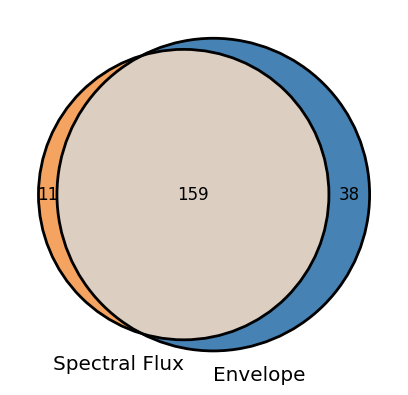

In [13]:
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles
fig, ax = plt.subplots(1,1)
matplotlib.rcParams.update({'font.size': 12})
c = venn2(subsets = (len(sf)-len(inter),len(env)-len(inter),  len(inter)),
      set_labels = ('Spectral Flux', 
                    'Envelope'),
      set_colors=('sandybrown','steelblue',),alpha=1,ax=ax)
# add outline
venn2_circles(subsets=(len(sf)-len(inter),len(env)-len(inter),  len(inter)),ax=ax) 
plt.show();

#fig.savefig("figure4highbottom.png",  dpi=300, format=None, metadata=None,
 #bbox_inches=None, pad_inches=0.1,  facecolor='white', edgecolor='white' )
